predicted_risk
0    73347
1    28156
Name: count, dtype: int64
risk_segment
Low       60388
Medium    28713
High      12402
Name: count, dtype: int64


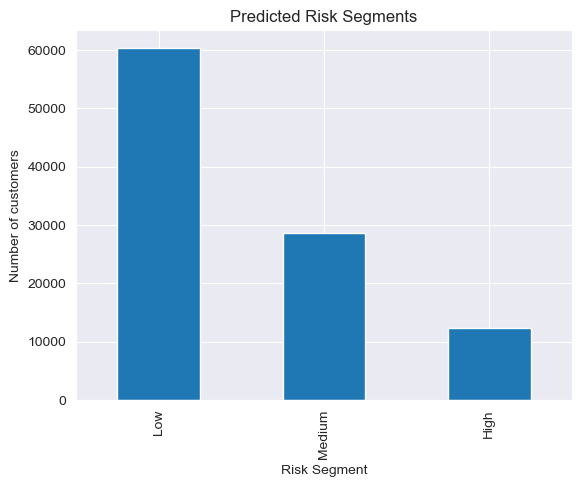

Predictions exported.


In [14]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

test = pd.read_csv(r'C:\Users\FENIL\Desktop\Projects\Loan_default\data\raw\cs-test.csv')

# Fill missing values as done in train
test['MonthlyIncome'] = test['MonthlyIncome'].fillna(test['MonthlyIncome'].median())
test['NumberOfDependents'] = test['NumberOfDependents'].fillna(test['NumberOfDependents'].mode()[0])

# Cap outliers
test.loc[test['DebtRatio'] > 99, 'DebtRatio'] = 99
test.loc[test['MonthlyIncome'] > 20000, 'MonthlyIncome'] = 20000

# Drop unnecessary columns
if 'Unnamed: 0' in test:
    test = test.drop(columns=['Unnamed: 0'])

# Feature engineering
delinq_cols = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]
if all(col in test.columns for col in delinq_cols):
    test['TotalPastDue'] = test[delinq_cols].sum(axis=1)
    test = test.drop(columns=delinq_cols)

test['HighDebtRatio'] = (test['DebtRatio'] > 0.5).astype(int)
test['HighIncome'] = (test['MonthlyIncome'] > 10000).astype(int)

# Ensure feature order
# Replace this with your real model's input order if needed:
model_feature_list = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome',
                      'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
                      'NumberOfDependents', 'TotalPastDue', 'HighDebtRatio', 'HighIncome']

X_test = test[model_feature_list]

with open('final_rf_model.pkl', 'rb') as f:
    best_rf = pickle.load(f)

probs_test = best_rf.predict_proba(X_test)[:, 1]
preds_test = best_rf.predict(X_test)

test['predicted_prob'] = probs_test
test['predicted_risk'] = preds_test

risk_bins = [0, 0.33, 0.66, 1.0]
risk_labels = ['Low', 'Medium', 'High']
test['risk_segment'] = pd.cut(test['predicted_prob'], bins=risk_bins, labels=risk_labels, include_lowest=True)

print(test['predicted_risk'].value_counts())
print(test['risk_segment'].value_counts())
test['risk_segment'].value_counts().plot(kind='bar', title='Predicted Risk Segments')
plt.xlabel('Risk Segment')
plt.ylabel('Number of customers')
plt.show()

test.to_csv(r'C:\Users\FENIL\Desktop\Projects\Loan_default\data\processed\test_final_predictions.csv', index=False)
print("Predictions exported.")
